# Part 1

In [283]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy.stats import norm, t
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from itertools import combinations

import warnings
warnings.filterwarnings('ignore')

In [284]:
df = pd.read_csv('framingham_heart_disease.csv')

### Section 1- Research question
We would like to explore the relations between: Number of cigaretes per day (discrete), total cholesterol (continous), diaBP (diastolic BP) and sysBP (systolic BP - continous). <br>
Hence, our research question would be:
**What are the effects of number of cigaretes per day, total cholesterol and diaBP over sysBP**

In [285]:
df.dropna(subset=['cigsPerDay', 'totChol', 'diaBP', 'sysBP'], inplace=True)

### Section 2

In [286]:
df_train, df_test, y_train, y_test = train_test_split(df[['cigsPerDay', 'totChol', 'diaBP']], df[['sysBP']], test_size=0.9519115171916326, random_state=42)

### Section 3.a

<AxesSubplot:>

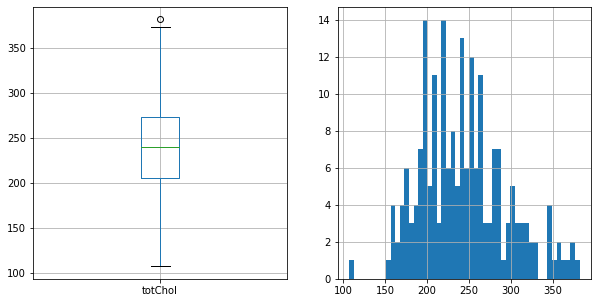

In [287]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
df_train.boxplot(column=['totChol'], ax=axes[0])
df_train['totChol'].hist(bins=50, ax=axes[1])

<AxesSubplot:>

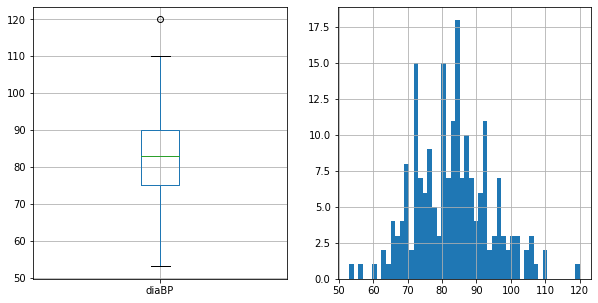

In [288]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
df_train.boxplot(column=['diaBP'], ax=axes[0])
df_train['diaBP'].hist(bins=50, ax=axes[1])

<AxesSubplot:>

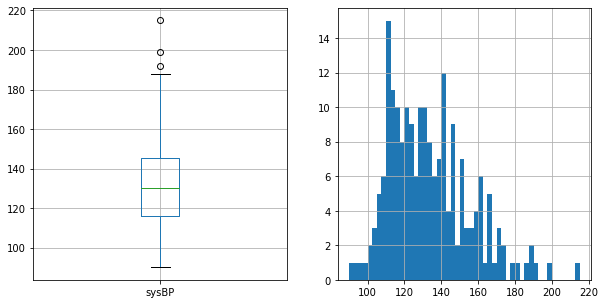

In [289]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
y_train.boxplot(column=['sysBP'], ax=axes[0])
y_train['sysBP'].hist(bins=50, ax=axes[1])

In [290]:
df_train.groupby('cigsPerDay').count().rename(columns={'totChol': 'count'})[['count']].transpose()

cigsPerDay,0.0,1.0,2.0,3.0,4.0,5.0,9.0,10.0,13.0,15.0,18.0,20.0,25.0,30.0,35.0,40.0,43.0,60.0
count,88,6,1,6,1,3,9,2,1,12,1,42,2,13,3,7,2,1


### Section 3.b
<ins>Missing values:</ins> We had NaN values for some of the columns but we took care of it by droping the rows containing them before section 2. Other methods of taking care of them would be to replace them with the average or median for example. Since we want to get a grasp of the relations between explaining variables to the explained variable, we would like to first use non-missing values to try and see the closest estimation for the real relationship.
<br><br>
<ins>abnormal data:</ins> There are few outliers in each of the continous variables and it is always after the upper whisker  and not below the lower whisker.Moreover, when looking at the cigsPerDay histogram we can see that there are many people not smoking (0 per day) and than many people smoking 20 cigaretes per day with lower volumes in between. This observation could indicate anomally which could result from the way the data was collected or other fenomenas related to people who smoke.
<br><br>
<ins>Distribution of the variables:</ins> We can see that the histogram of totChol and diaBP resembles normal distribution, and the sysBP's histogram resembles chi-squre or gamma distribution since it seems to have a heavy tail in contrast to the first two variables.
Estimating the distribution of cigsPerDay is harder since it is discrete but it looks like multinomial with higher probabilities for 0 & 20.

### Section 3.c

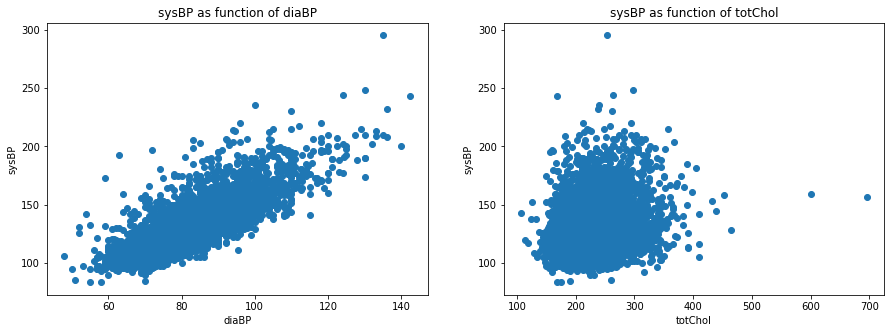

In [291]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
for i, col in enumerate(['diaBP', 'totChol']):
    axes[i].scatter(df[col], df['sysBP'])
    axes[i].set_title(f'sysBP as function of {col}')
    axes[i].set_ylabel('sysBP')
    axes[i].set_xlabel(f'{col}')

<ins>Concolusion:</ins> It looks like diaBP column has strong positive correlation with sysBP, while the totChol has almost no correlation at all to sysBP.

### Section 3.d

Text(0, 0.5, 'sysBP')

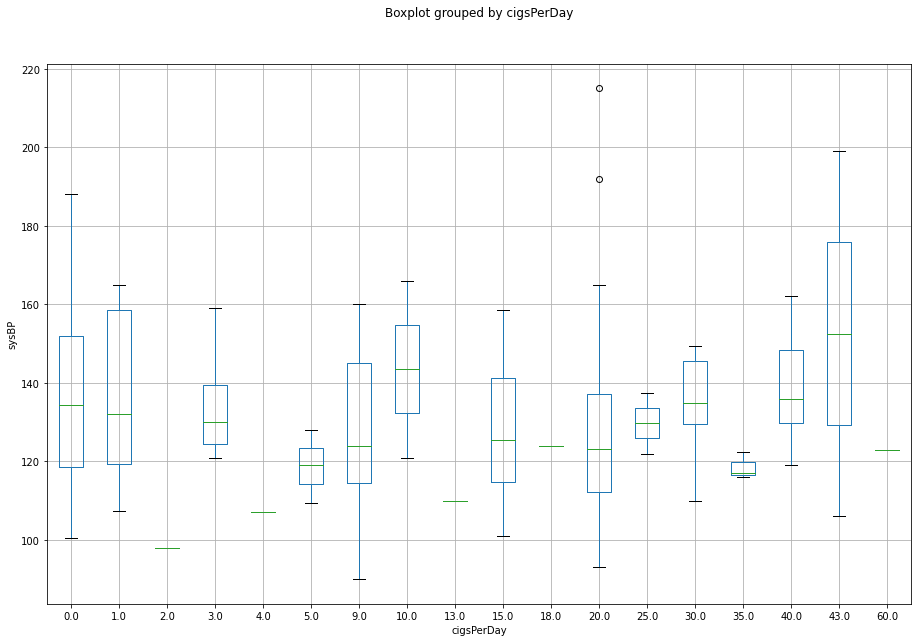

In [292]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,10))
df_cigsSysBp = pd.concat([df_train[['cigsPerDay']], y_train], axis=1)
df_cigsSysBp.boxplot(by='cigsPerDay', ax=axes)
axes.set_title('')
axes.set_xlabel('cigsPerDay')
axes.set_ylabel('sysBP')

### Section 4

In [293]:
X = sm.add_constant(df_train)
model = sm.OLS(y_train,X)
results = model.fit()
results.params

const        -6.795017
cigsPerDay   -0.002428
totChol       0.055739
diaBP         1.520925
dtype: float64

As we concluded from the scatter plots, we can see that diaBP has the largest absolute value of multiplier in $\hat{\beta}$ while cigsPerDay and totChol's multipliers are closer to zero.

In [294]:
for col in df_train.columns:
    temp_df = df_train[:5].copy()
    temp_df[col] += 1
    X_1 = sm.add_constant(temp_df)
    X = sm.add_constant(df_train[:5])
    print(f'predict(X+1) - predict(X) = {results.predict(X_1) - results.predict(X)}')

predict(X+1) - predict(X) = 1799   -0.002428
986    -0.002428
2725   -0.002428
2730   -0.002428
1325   -0.002428
dtype: float64
predict(X+1) - predict(X) = 1799    0.055739
986     0.055739
2725    0.055739
2730    0.055739
1325    0.055739
dtype: float64
predict(X+1) - predict(X) = 1799    1.520925
986     1.520925
2725    1.520925
2730    1.520925
1325    1.520925
dtype: float64


We can see that the diffrence between the predication of (X(i)+ 1) to the predication of (X(i)) (for i=1,2,3) is exactly the corresponding parameter.

### Section 5

In [295]:
def anova_table(model):
    dict_anova = {'Source of Variation': ['Regression', 'Residual error', 'Total'],
                  'DF':[4, model.nobs - 4, model.nobs - 1],
                  'SS': [(model.mse_model)*3, model.mse_resid*(model.nobs - 4),model.mse_total*(model.nobs - 1)],
                  'MS': [model.mse_model, model.mse_resid, model.mse_total],
                  'F': [model.mse_model/model.mse_resid, '-', '-'],
                  'F-Pvalue': [model.f_pvalue,'-', '-']
                 }
    r = ((model.mse_model)*3) /(model.mse_total*(model.nobs - 1)) 
    print('**Anova Table**')
    print(pd.DataFrame(dict_anova))
    print()
    print('**R^2**')
    print(r)
    print()
    print('**R^2 adj**')
    print(1-((model.nobs - 1)/(model.nobs - 4))*(1-r))

In [296]:
anova_table(results)

**Anova Table**
  Source of Variation     DF           SS            MS           F F-Pvalue
0          Regression    4.0  60707.27209  20235.757363  113.108493      0.0
1      Residual error  196.0  35065.52291    178.905729           -        -
2               Total  199.0  95772.79500    481.270327           -        -

**R^2**
0.6338676039469489

**R^2 adj**
0.6282635366604226


### Section 6

In [297]:
results.conf_int()

,0,1
const,-22.772409,9.182376
cigsPerDay,-0.149387,0.144531
totChol,0.018248,0.093230
diaBP,1.346634,1.695215


In [298]:
df_all = df[['cigsPerDay', 'totChol', 'diaBP']]

In [299]:
X = sm.add_constant(df_all)
model_all = sm.OLS(df[['sysBP']],X)
results_all = model.fit()
results_all.params

const        -6.795017
cigsPerDay   -0.002428
totChol       0.055739
diaBP         1.520925
dtype: float64

As expected, we can see that all $\forall j\in[0,3]: \hat{\beta_j}$ is in the confidence interval estimated based on the sub-sample.

### Section 7
The statistical test we would like to perform is the F test, to see houw well does the regression model fits the data.
Out hypothesises are: $H_0: \forall i\in(0,1,2,3):\; \beta_i=0$, $H_1: \exists i\in(0,1,2,3)\; s.t:\; \beta_i\neq0$<br>
We saw in the ANOVA table the the p-value for F test was 0, meaning we will reject the null hypothesis at all confidence levels, hence there exists some coefficients that are different from zero.

### Section 8

In [300]:
y_predicted = results.predict(sm.add_constant(df_train))

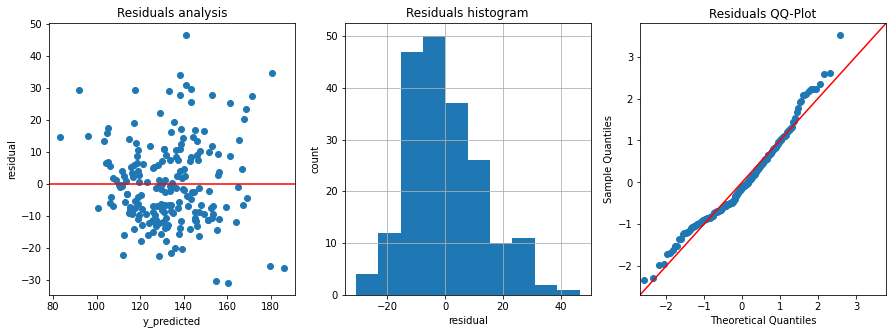

In [301]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

# Residuals plot
axes[0].scatter(y_predicted, results.resid)
axes[0].axhline(0,0, color='r')
axes[0].set_title('Residuals analysis')
axes[0].set_xlabel('y_predicted')
axes[0].set_ylabel('residual')

# Histogram for the residuals
results.resid.hist(ax=axes[1])
axes[1].set_title('Residuals histogram')
axes[1].set_xlabel('residual')
axes[1].set_ylabel('count')

# QQ-Plot for the residuals
sm.qqplot(results.resid, norm, fit=True, line="45", ax=axes[2])
axes[2].set_title('Residuals QQ-Plot')

plt.show()

<ins>Linearity assumption:</ins> As we can see in the residual analysis plot, there is no pattern or symmetry of the residuals around e=0 line. This could indicate that the linear model has catched most of the information but the noise itself, hence linearity is plausable.
<br><br>
<ins>Homoscedaticity:</ins> Also from the residual analysis plot we can deduce that the assumption of homosecedaticity is not that plausable, since the residuals are not equally spread over the plot.
<br><br>
<ins>Residual's distribution:</ins> As we can see from the histogram and the QQ-Plot, the assumption for normal distribution over the residuals is plausable.

### Section 9

In [302]:
def calc_ci(sign, x_i, y_i, sigma_squared, ci_t_percentile, C):
    return y_i + sign*(ci_t_percentile*np.sqrt(sigma_squared*(1+x_i.T@C@x_i)))

In [303]:
new_df = pd.concat([df_test, y_test], axis=1).sample(1000)
new_y_test = new_df[['sysBP']]
new_df = new_df[['cigsPerDay', 'totChol', 'diaBP']]

y_predicted = results.predict(sm.add_constant(new_df))

In [304]:
# Since the variance is unknown we will compute it using the unbiased estimator as shown in tutorial 5
dof = len(df_train)-2
sigma_squared = np.dot(results.resid.to_numpy().T,results.resid.to_numpy())/(len(new_df)-4)
ci_t_percentile = t(df=dof).ppf(0.95)
C = np.linalg.inv(np.matmul(new_df.to_numpy().T,new_df.to_numpy()))  # C = (X.T * X)^-1
CI = [(calc_ci(-1, x_i, y_i, sigma_squared, ci_t_percentile, C),
      calc_ci(1, x_i, y_i, sigma_squared, ci_t_percentile, C)) for (x_i,y_i) in zip(new_df.to_numpy(),y_predicted)]

In [305]:
sum([c_l<y_i[0]<c_u for ((c_l, c_u), y_i) in zip(CI, new_y_test.to_numpy())])/len(CI)

0.591

As we can see, not all real values actually fits into the confidence intervals. This could be indicating that our linearity assumption about the true model is not accurate and we did not capture all of the information from the data relevant for the predictions. <br>
Moreover, this results correlates to the $R^2$ measure we saw in section 5, which was ~0.62. Implicating our linear model was able to explain ~0.6 of the relations.

### Section 10
We will use both cross validation and Mallow Cp to evaluate which model is better.

In [306]:
poly = PolynomialFeatures(interaction_only=True,include_bias=True)
interactions_array = poly.fit_transform(df_train)

regular_array = np.concatenate([np.ones((200,1)), df_train.to_numpy()], axis=1)
y_array = [y[0] for y in y_train.to_numpy()]

clf = LinearRegression()

In [307]:
scores = cross_val_score(clf, regular_array, y_array, cv=5)
print(f'CV mean for linear model: {scores.mean()}, CV std: {scores.std()}')

CV mean for linear model: 0.5930852758952643, CV std: 0.0758710436202672


In [308]:
scores = cross_val_score(clf, interactions_array, y_array, cv=5)
print(f'CV mean for interaction model: {scores.mean()}, CV std: {scores.std()}')

CV mean for interaction model: 0.5882636099787204, CV std: 0.08362270119532977


In [309]:
def get_mallow_cp(clf, y_true, num_features, array):
    # Mallow Cp = RSE + number_of_features*sigma_squared
    y_predicted = clf.predict(array)
    sigma_squared = np.dot((y_true - np.mean(y_true)).T, (y_true - np.mean(y_true)))/(len(y_true)-2)
    RSE = len(y_true)*mean_squared_error(y_true, y_predicted)
    return RSE + 2*num_features*sigma_squared

In [310]:
clf_linear = LinearRegression()
clf_linear.fit(regular_array, y_array)
linear_num_features = 4  # bias and three variables

clf_interactions = LinearRegression()
clf_interactions.fit(interactions_array, y_array)
interatction_num_features = 7  # bias and 6 variables

print(f'Mallow-Cp for linear model: {get_mallow_cp(clf_linear, y_array, linear_num_features, regular_array)}, Mallow-Cp for interactions model: {get_mallow_cp(clf_interactions, y_array, interatction_num_features, interactions_array)}')

Mallow-Cp for linear model: 38935.13078883557, Mallow-Cp for interactions model: 40565.241155089876


We can see that the regular linear model recieved higher scores for the mean over 5-fold cross validation and lower scores on Mallow Cp (which we wish to minimize). This could indicate that the linear model describes the data better than the interactions model.
Nevertheless, the differences both for the 5-fold mean and the Mallow-Cp are not big so this is not conclusive.

# Part 2

### Section 1
For this part we will choose the same explaining variables (cigsPerDay, totChol, diaBP) and the explained variable would be TenYearsCHD (which is binary, indicating having disease or not).<br>
Hence, our research question would be:
**What are the effects of number of cigaretes per day, total cholesterol and diaBP over TenYearCHD**

### Section 2

In [311]:
df_train, df_test, y_train, y_test = train_test_split(df[['cigsPerDay', 'totChol', 'diaBP']], df[['TenYearCHD']], test_size=0.9519115171916326, random_state=42)

### Section 3
We will explore only the explained variable - TenYearCHD, since we explored all others in the first part

In [312]:
y_train.value_counts()

TenYearCHD
0             173
1              27
dtype: int64

We can see the the explained variabe is a little bit biased towards the value 0 (1 value indicates this person has 10-year risk of coronary heart disease). We would wish that the ratio between those binary values would be close enough to the real ratio in the population. <br>
We dropped all the null values of the explaining variable in the previous part.

### Section 4
Let's check the boxplot-graph for each explained variable.

Text(0.5, 0, 'TenYearCHD')

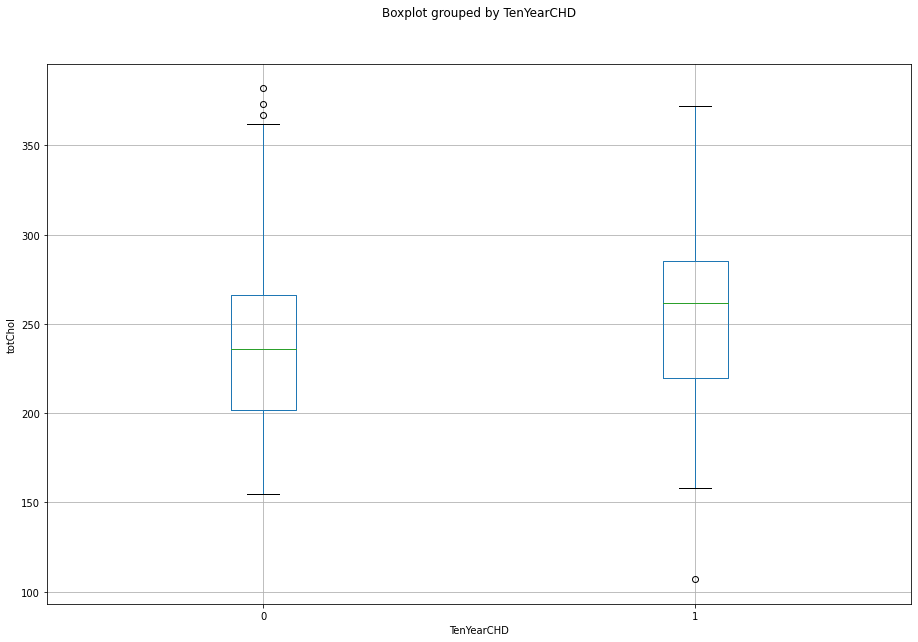

In [313]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,10))
df_totChol = pd.concat([df_train[['totChol']], y_train], axis=1)
df_totChol.boxplot(by='TenYearCHD', ax=axes)
axes.set_title('')
axes.set_ylabel('totChol')
axes.set_xlabel('TenYearCHD')

Text(0.5, 0, 'TenYearCHD')

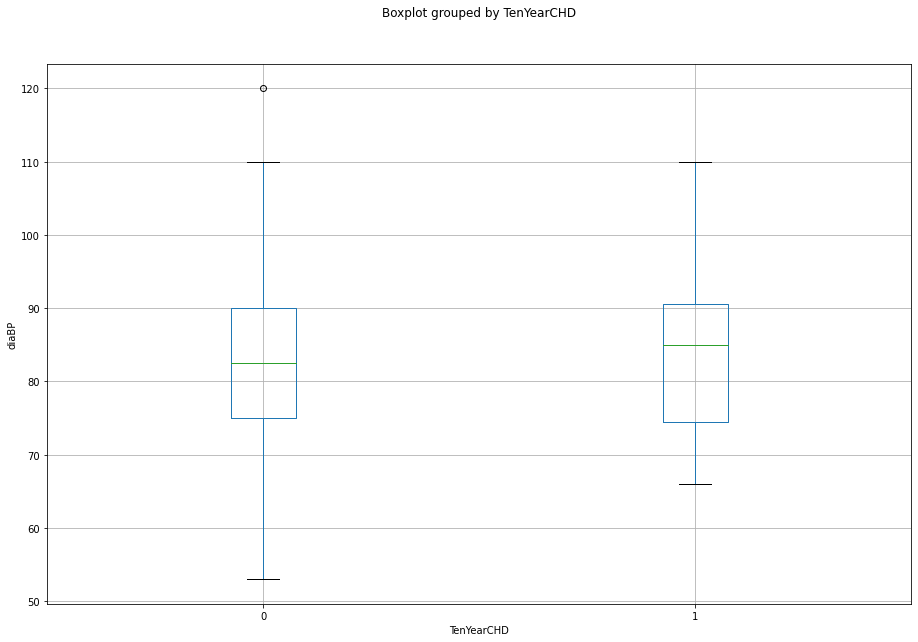

In [314]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,10))
df_diaBP = pd.concat([df_train[['diaBP']], y_train], axis=1)
df_diaBP.boxplot(by='TenYearCHD', ax=axes)
axes.set_title('')
axes.set_ylabel('diaBP')
axes.set_xlabel('TenYearCHD')

As we can the the two IQRs of the totChol variable (one for TenYearCHD=1 and one for TenYearCHD=0) have different values and more specific the medians have different values in each category. In contrast the diaBP IQRs are more similar to each other (in each category of the TenYearCHD), so it looks like the totChol influences on the explain variable more than diaBP.

Let's find $\hat{\beta}$ variable

In [315]:
X = sm.add_constant(df_train)
model = sm.Logit(y_train,X)
results = model.fit()
results.params

Optimization terminated successfully.
         Current function value: 0.369074
         Iterations 6


const        -4.619794
cigsPerDay    0.043206
totChol       0.007608
diaBP         0.003538
dtype: float64

In [316]:
for col in df_train.columns:
    temp_df = df_train[:5].copy()
    temp_df[col] += 1
    X_1 = sm.add_constant(temp_df)
    X = sm.add_constant(df_train[:5])
    top = np.log(results.predict(X_1) / (1- results.predict(X_1)))
    down = np.log(results.predict(X) / (1- results.predict(X)))
    print(f'logit(predict(X+1)) - logit(predict(X)) = {top - down}')

logit(predict(X+1)) - logit(predict(X)) = 1799    0.043206
986     0.043206
2725    0.043206
2730    0.043206
1325    0.043206
dtype: float64
logit(predict(X+1)) - logit(predict(X)) = 1799    0.007608
986     0.007608
2725    0.007608
2730    0.007608
1325    0.007608
dtype: float64
logit(predict(X+1)) - logit(predict(X)) = 1799    0.003538
986     0.003538
2725    0.003538
2730    0.003538
1325    0.003538
dtype: float64


We can see that the diffrence between the logit of the predication of (X(i)+ 1) to the logit of the predication of (X(i)) (for i=1,2,3) is exactly the corresponding parameter (as expected).

### Section 5

In [317]:
results.conf_int()

,0,1
const,-8.185496,-1.054092
cigsPerDay,0.013688,0.072724
totChol,-0.000672,0.015888
diaBP,-0.035792,0.042867


In [318]:
df_all = df[['cigsPerDay', 'totChol', 'diaBP']]
X = sm.add_constant(df_all)
model_all = sm.OLS(df[['sysBP']],X)
results_all = model.fit()
results_all.params

Optimization terminated successfully.
         Current function value: 0.369074
         Iterations 6


const        -4.619794
cigsPerDay    0.043206
totChol       0.007608
diaBP         0.003538
dtype: float64

As expected, we can see that all $\forall j\in[0,3]: \hat{\beta_j}$ is in the confidence interval estimated based on the sub-sample.

### Section 6

In [319]:
poly = PolynomialFeatures(interaction_only=True,include_bias=True)
interactions_array = poly.fit_transform(df_train)

regular_array = np.concatenate([np.ones((200,1)), df_train.to_numpy()], axis=1)
y_array = [y[0] for y in y_train.to_numpy()]

clf = LogisticRegression(random_state=0)

In [320]:
scores = cross_val_score(clf, regular_array, y_array, cv=5)
print(f'CV mean for linear model: {scores.mean()}, CV std: {scores.std()}')

CV mean for linear model: 0.865, CV std: 0.020000000000000018


In [321]:
scores = cross_val_score(clf, interactions_array, y_array, cv=5)
print(f'CV mean for interaction model: {scores.mean()}, CV std: {scores.std()}')

CV mean for interaction model: 0.86, CV std: 0.025495097567963948


In [322]:
clf_linear = LogisticRegression(random_state=0)
clf_linear.fit(regular_array, y_array)
linear_num_features = 4  # bias and three variables

clf_interactions = LogisticRegression(random_state=0)
clf_interactions.fit(interactions_array, y_array)
interatction_num_features = 7  # bias and 6 variables

print(f'Mallow-Cp for linear model: {get_mallow_cp(clf_linear, y_array, linear_num_features, regular_array)}, Mallow-Cp for interactions model: {get_mallow_cp(clf_interactions, y_array, interatction_num_features, interactions_array)}')

Mallow-Cp for linear model: 27.943636363636365, Mallow-Cp for interactions model: 29.65136363636364


We can see that the regular linear model recieved higher scores for the mean over 5-fold cross validation and lower scores on Mallow Cp (which we wish to minimize). This could indicate that the linear model describes the data better than the interactions model.
Nevertheless, the differences both for the 5-fold mean and the Mallow-Cp are not big so this is not conclusive.

### Section 7
We wiil use cross-validation in both forward and backward stepwise regression

In [323]:
def forward_stepwise_regression(clf, array: np.array, labels, scoring_function, is_cv=True, num_folds=5):
    """
    clf is an sklearn classifier.
    array is the data to be trained on, with bias column prepended, with interactions already - postpended
    """
    best_vars = tuple()
    num_features = array.shape[1]
    features = list(range(num_features))
    best_score = float('-inf') if is_cv else float('inf')
    while len(features) > 0:
        features = list(filter(lambda x: x not in best_vars, features))
        curr_best_score = float('-inf') if is_cv else float('inf')
        curr_best_vars = []
        for feature in features:
            temp_vars = best_vars + (feature,)
            temp_array = array[:, temp_vars]
            if not is_cv:
                clf.fit(temp_array, labels)
                temp_score = scoring_function(clf, labels, len(temp_vars), temp_array)
                if temp_score < curr_best_score:
                    curr_best_vars = temp_vars
                    curr_best_score = temp_score
            else:
                temp_score = scoring_function(clf, temp_array, labels, cv=num_folds).mean()
                if temp_score > curr_best_score:
                    curr_best_vars = temp_vars
                    curr_best_score = temp_score
        if (is_cv and curr_best_score > best_score) or (not is_cv and curr_best_score < best_score):
            best_vars = curr_best_vars
            best_score = curr_best_score
        else:
            break
    return best_vars, best_score

In [324]:
poly = PolynomialFeatures(interaction_only=True,include_bias=True)
X = df[[col for col in df.columns if col != 'TenYearCHD']].dropna()
y_true = df.dropna()['TenYearCHD'].to_numpy()
interactions_array = poly.fit_transform(X)

In [325]:
scoring_function = cross_val_score
clf = LogisticRegression(random_state=0)
best_vars, max_score = forward_stepwise_regression(clf, interactions_array, y_true, scoring_function)

In [326]:
print(f"The chosen features according to forward stepwise regression are:{[poly.get_feature_names(X.columns)[i] for i in best_vars]} with max score of: {max_score}")

The chosen features according to forward stepwise regression are:['prevalentHyp glucose', 'male diabetes', 'male heartRate'] with max score of: 0.8509299335441382


In [327]:
def backward_stepwise_regression(clf, df, labels, scoring_function):
    num_samples = len(df)
    poly = PolynomialFeatures(interaction_only=True,include_bias=True)
    array = poly.fit_transform(df)
    features_names = list(poly.get_feature_names(df.columns))
    if scoring_function == cross_val_score:
        f = max
        scoring_args = {'estimator': clf, 'X': array, 'y': labels, 'cv':5}
        old_score = float('-inf')
    else:
        f = min
        old_score = float('inf')
        scoring_args = {'clf': clf, 'array': array, 'y_true': labels}
    while True:
        score_list = []
        num_features = len(features_names)
        for i, c in enumerate(features_names):
            temp_df = np.delete(array, i, 1)
            if scoring_function == cross_val_score:
                scoring_args['X'] = temp_df
            else:
                scoring_args['num_features'] = num_features
                scoring_args['array'] = temp_df
                clf.fit(temp_df, labels)
            score = scoring_function(**scoring_args)
            if scoring_function == cross_val_score:
                score_list.append((c, sum(score)/len(score), i))
            else:
                score_list.append((c, score, i))
        new_score = f(score_list, key=lambda x: x[1])
        if f(new_score[1], old_score) == new_score[1] and new_score[1] != old_score:
            old_score = new_score[1]
            features_names.remove(new_score[0])
            array = np.delete(array, new_score[2], 1)
        else:
            return features_names, old_score

In [328]:
best_vars_back, best_score_back = backward_stepwise_regression(clf, X, y_true, cross_val_score)

In [329]:
print(f"The chosen features according to backward stepwise regression are:{best_vars_back} with max score of: {best_score_back}")

The chosen features according to backward stepwise regression are:['1', 'male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose', 'male age', 'male education', 'male currentSmoker', 'male cigsPerDay', 'male BPMeds', 'male prevalentStroke', 'male prevalentHyp', 'male diabetes', 'male sysBP', 'male diaBP', 'male BMI', 'male heartRate', 'male glucose', 'age education', 'age currentSmoker', 'age cigsPerDay', 'age BPMeds', 'age prevalentStroke', 'age prevalentHyp', 'age diabetes', 'age totChol', 'age sysBP', 'age diaBP', 'age BMI', 'age heartRate', 'age glucose', 'education currentSmoker', 'education cigsPerDay', 'education BPMeds', 'education prevalentStroke', 'education prevalentHyp', 'education diabetes', 'education totChol', 'education sysBP', 'education diaBP', 'education BMI', 'education heartRate', 'education glucose', 'currentSmoker cigsPerDay', 'currentSmoker BPMeds

### Section 8
We will use Mallow Cp this time for both mehotds

In [330]:
clf = LogisticRegression(random_state=0, solver='liblinear')
best_vars, max_score = forward_stepwise_regression(clf, interactions_array, y_true, get_mallow_cp, is_cv=False)

In [331]:
print(f"The chosen features according to forward stepwise regression are:{[poly.get_feature_names(X.columns)[i] for i in best_vars]} with max score of: {max_score}")

The chosen features according to forward stepwise regression are:['prevalentHyp glucose', 'male diabetes', 'cigsPerDay prevalentStroke'] with max score of: 545.7752705586876


In [ ]:
best_vars_back, best_score_back = backward_stepwise_regression(clf, X, y_true, get_mallow_cp)

In [ ]:
print(f"The chosen features according to backward stepwise regression are:{best_vars_back} with max score of: {best_score_back}")